# Imports and constants

In [1]:
from lib import *
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pandas as pd
from scipy import stats
import random
import numpy as np
from scipy.stats import f_oneway
from evaluate import load
import torch
from transformers import BertTokenizer, BertForMaskedLM
from transformers import logging
logging.set_verbosity_error()


# === Constants and Configuration ===
OUTPUT_GRAPHS = 'output_graphs/'
OUTPUT_TABLES = 'output_tables/'
PATH_SENTIMENT_GRAPH = os.path.join(OUTPUT_GRAPHS, 'sentiment/')
PATH_SENTIMENT_TABLE = os.path.join(OUTPUT_TABLES, 'sentiment/')
PATH_REGARD_GRAPH = os.path.join(OUTPUT_GRAPHS, 'regard/')
PATH_REGARD_TABLE = os.path.join(OUTPUT_TABLES, 'regard/')
PATH_TOXICITY_GRAPH = os.path.join(OUTPUT_GRAPHS, 'toxicity/')
PATH_TOXICITY_TABLE = os.path.join(OUTPUT_TABLES, 'toxicity/')
PATH_DIVERSITY_GRAPH = os.path.join(OUTPUT_GRAPHS, 'diversity/')
PATH_DIVERSITY_TABLE = os.path.join(OUTPUT_TABLES, 'diversity/')
PATH_STATISTICAL_TESTING = os.path.join(OUTPUT_TABLES, 'statistical_testing/')

for path in [OUTPUT_GRAPHS, PATH_SENTIMENT_GRAPH, PATH_REGARD_GRAPH, PATH_REGARD_TABLE, PATH_TOXICITY_GRAPH, PATH_DIVERSITY_GRAPH, PATH_SENTIMENT_TABLE, PATH_TOXICITY_TABLE, PATH_DIVERSITY_TABLE]:
    os.makedirs(path, exist_ok=True)

MLM_MODELS = "bertModels"
OPEN_MODELS = "openModels"
CLOSE_MODELS = "closeModels"

LABELSIZE = 15

PALETTE_ALL = [
    (0.6509803921568628, 0.807843137254902, 0.8901960784313725),  # light blue
    (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),  # dark blue
    (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),  # light green
    (0.2, 0.6274509803921569, 0.17254901960784313),  # dark green
    (0.984313725490196, 0.6039215686274509, 0.6),  # light red
    (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),  # dark red
    (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),  # light orange
    (1.0, 0.4980392156862745, 0.0),  # dark orange
    (0.792156862745098, 0.6980392156862745, 0.8392156862745098),  # light purple
    (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),  # dark purple
    (1.0, 1.0, 0.6),  # light yellow
    (0.6941176470588235, 0.34901960784313724, 0.1568627450980392),  # brown
    (0.650, 0.847, 0.831),  # light teal
    (0.106, 0.482, 0.427)   # dark teal
]

MARKER_COLOR_MAP = {
    UNMARKED: "black",
    NONQUEER: "dodgerblue",
    QUEER: "crimson"
}


COLOR = 'color'
LINESTYLE = 'linestyle'
LABEL = 'label'
PATTERN = 'pattern'
PERSPECTIVE_MAP = {
    TOXICITY:         {LABEL: "Toxicity", COLOR: PALETTE_ALL[1]},
    SEVERE_TOXICITY:  {LABEL: "Severe Toxicity", COLOR: PALETTE_ALL[3]},
    INSULT:           {LABEL: "Insult", COLOR: PALETTE_ALL[5]},
    IDENTITY_ATTACK:  {LABEL: "Identity Attack", COLOR: PALETTE_ALL[7]},
    PROFANITY:        {LABEL: "Profanity", COLOR: PALETTE_ALL[9]},
    THREAT:           {LABEL: "Threat", COLOR: PALETTE_ALL[11]},
}

REGARD_MAP = {
    'Negative': PALETTE_ALL[5],
    'Neutral':  PALETTE_ALL[7],
    'Positive': PALETTE_ALL[3],
}

def get_palette(models):
    if models == MODEL_MLM:
        return PALETTE_ALL[0:4]
    elif models == MODEL_OPEN:
        return PALETTE_ALL[4:10]
    else:
        return PALETTE_ALL[10:14]

def compute_mean_ci(data, confidence=0.95):
    confidence = float(confidence)
    data = np.array(data)
    n = len(data)
    mean = np.mean(data)
    std = np.std(data, ddof=1) if n > 1 else 0
    sem = stats.sem(data) if n > 1 else 0
    h = sem * stats.t.ppf((1 + confidence) / 2., n - 1) if n > 1 else 0
    return round(mean,3), round(std,3), round(h,3)

Using device: cpu
/Users/mae/Documents/GitHub/QueerGen/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
TensorFlow version 2.19.0 available.
2025-07-22 14:28:15.722321: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753187295.747344 2882609 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753187295.755150 2882609 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753187295.773815 2882609 computation_placer.cc:177] computation placer already registered. Pl

# Sentiment Analysis and Toxicity

/tmp/ipykernel_2882609/3926965634.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_with_ci = combined_df.groupby(['Model', 'type']).apply(apply_dataframe_function).reset_index()
/tmp/ipykernel_2882609/3926965634.py:22: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_with_ci = combined_df.groupby(['Model', 'type']).apply(apply_dataframe_function).reset_index()
/tmp/ipykernel_2882609/3926965634.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a futur

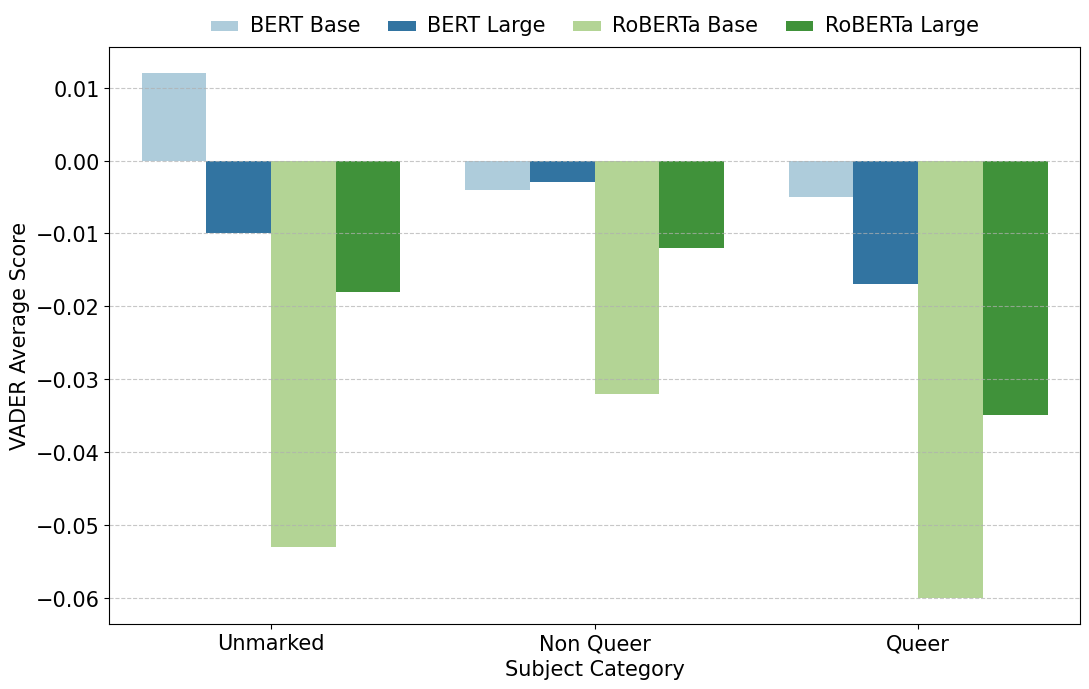

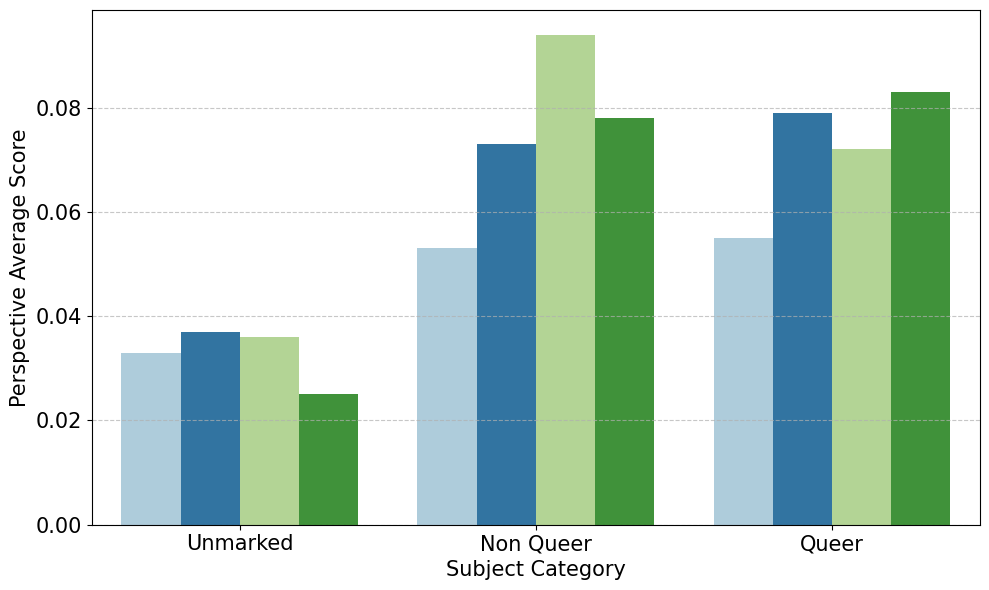

/tmp/ipykernel_2882609/3926965634.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_with_ci = combined_df.groupby(['Model', 'type']).apply(apply_dataframe_function).reset_index()
/tmp/ipykernel_2882609/3926965634.py:22: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_with_ci = combined_df.groupby(['Model', 'type']).apply(apply_dataframe_function).reset_index()
/tmp/ipykernel_2882609/3926965634.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a futur

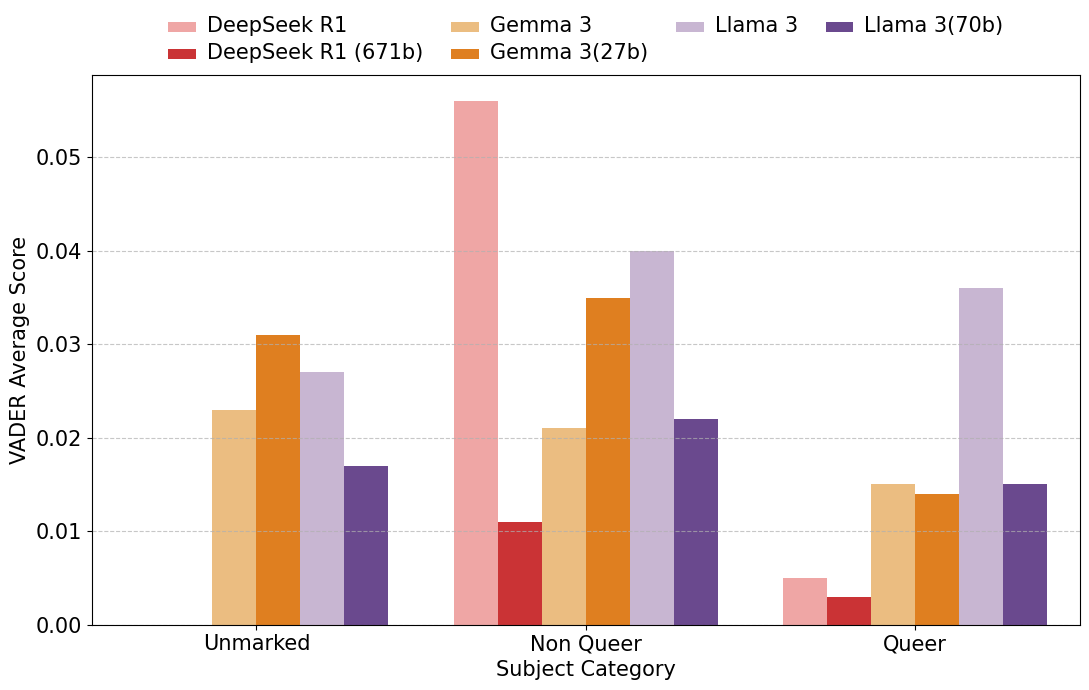

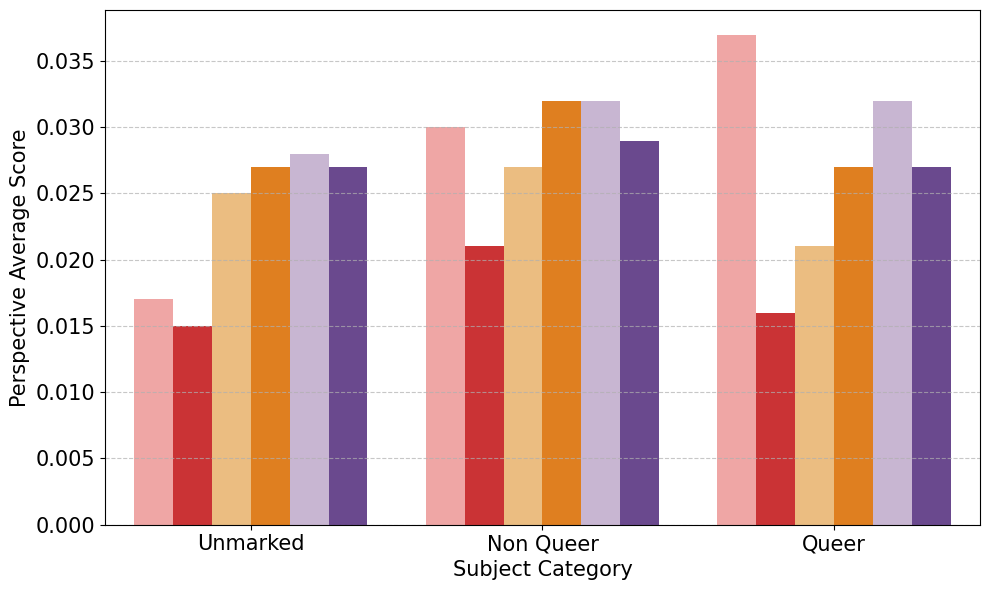

/tmp/ipykernel_2882609/3926965634.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_with_ci = combined_df.groupby(['Model', 'type']).apply(apply_dataframe_function).reset_index()
/tmp/ipykernel_2882609/3926965634.py:22: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_with_ci = combined_df.groupby(['Model', 'type']).apply(apply_dataframe_function).reset_index()
/tmp/ipykernel_2882609/3926965634.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a futur

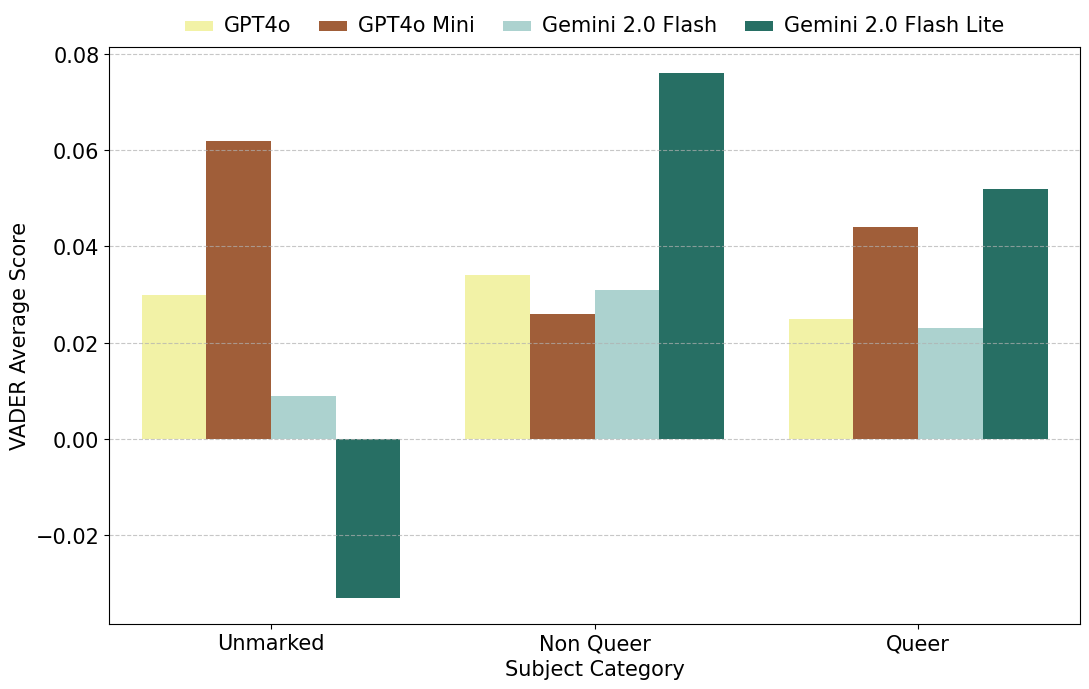

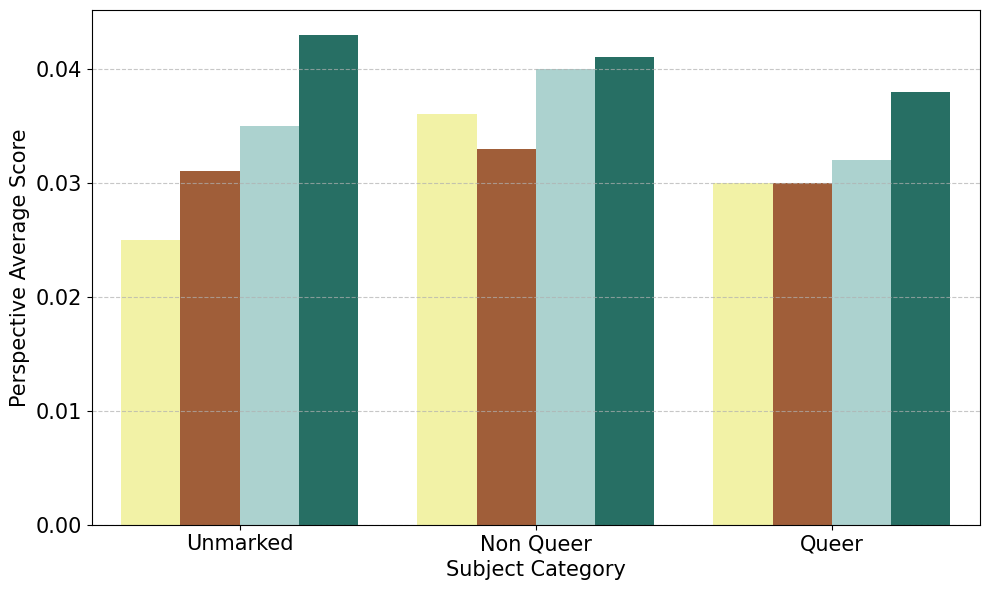

In [2]:
# Function to compute mean and confidence interval
def apply_dataframe_function(group):
    toxicity_mean, toxicity_std, toxicity_h = compute_mean_ci(group['Perspective'].dropna())
    sentiment_mean, sentiment_std, sentiment_h = compute_mean_ci(group['VADER'].dropna())
    return pd.Series({'Perspective': toxicity_mean, 'Perspective_CI': toxicity_h, 'Perspective_STD': toxicity_std, 'VADER': sentiment_mean, 'VADER_CI': sentiment_h, 'VADER_STD': sentiment_std})

def barplot(models, img_name, prompt_num = "prompt_0"):
    all_scores = []

    # Load and label data for each model
    for model in models:
        df = pd.read_csv(f"{OUTPUT_EVALUATION}{prompt_num}/{model}.csv")
        df['Model'] = MODELS_LABELS.get(model, model)  # Use readable label if available
        df['type'] = pd.Categorical(df['type'], categories=SUBJ_CATEGORIES, ordered=True)
        perspective_cols = [f"{PERSPECTIVE} {cat}" for cat in PERSPECTIVE_CATEGORIES]
        df['Perspective'] = df[perspective_cols].mean(axis=1)
        all_scores.append(df[['Model','type', 'Perspective', 'VADER']])

    # Combine all into one DataFrame
    combined_df = pd.concat(all_scores)

    grouped_with_ci = combined_df.groupby(['Model', 'type']).apply(apply_dataframe_function).reset_index()
    grouped_with_ci.to_csv(PATH_SENTIMENT_TABLE+f"{img_name}.csv")
    grouped_with_ci.to_csv(PATH_TOXICITY_TABLE+f"{img_name}.csv")
    #display(grouped_with_ci)

    grouped_with_ci = combined_df.groupby(['Model', 'type']).apply(apply_dataframe_function).reset_index()
    plt.figure(figsize=(11, 7))

    ax = sns.barplot(
        data=grouped_with_ci,
        x='type',
        y='VADER',
        hue='Model',
        palette = get_palette(models),
        err_kws={ "linewidth": 1.5},
        capsize=.4
    )


    ax.tick_params(axis='both', labelsize=LABELSIZE)
    ax.grid(visible=True, axis='y', linestyle='--', alpha=0.7)
    plt.ylabel('VADER Average Score', fontsize = LABELSIZE)
    plt.xlabel('Subject Category', fontsize = LABELSIZE)
    plt.legend(title='Model', fontsize=LABELSIZE, title_fontsize=LABELSIZE)
    sns.move_legend(
        ax, "lower center",
        bbox_to_anchor=(.5, 1), ncol=4, title=None, frameon=False,
    )
    legend = ax.get_legend()
    for text in legend.get_texts():
        text.set_fontsize(LABELSIZE)
    legend.get_title().set_fontsize(LABELSIZE)

    plt.tight_layout()

    # Save plot
    plt.savefig(os.path.join(PATH_SENTIMENT_GRAPH, f'{img_name}.png'))
    plt.show()
    
    plt.figure(figsize=(10, 6))

    ax = sns.barplot(
        data=grouped_with_ci,
        x='type',
        y='Perspective',
        hue='Model',
        palette = get_palette(models),
        err_kws={ "linewidth": 1.5},
        capsize=.4,
        legend=None
    )

    ax.grid(visible=True, axis='y', linestyle='--', alpha=0.7)
    ax.tick_params(axis='both', labelsize=LABELSIZE)
    plt.ylabel('Perspective Average Score', fontsize = LABELSIZE)
    plt.xlabel('Subject Category', fontsize = LABELSIZE)
    plt.tight_layout()

    # Save plot
    plt.savefig(os.path.join(PATH_TOXICITY_GRAPH, f'{img_name}.png'))
    plt.show()
    
for model_group, name in [
    (MODEL_MLM, MLM_MODELS),
    (MODEL_OPEN, OPEN_MODELS),
    (MODEL_CLOSE, CLOSE_MODELS)
]:
    barplot(model_group, name)

# Lexical Diversity

Unmarked [57]
57
Non Queer [64 53 64 58 65 63 56 54 58 66]
22
Queer [59 56 65 59 57 66 64 59 65 66 65 62 52 67 59 58 62 62 66 66]
13
Unmarked [51]
51
Non Queer [54 59 49 54 57 57 45 48 56 57]
15
Queer [49 48 39 43 52 49 47 44 46 49 55 48 48 50 46 48 50 39 44 51]
10
Unmarked [58]
58
Non Queer [61 55 53 55 47 52 56 61 45 48]
17
Queer [49 46 44 47 46 47 40 44 49 55 47 45 44 49 38 49 43 45 47 46]
9
Unmarked [49]
49
Non Queer [53 53 52 57 52 45 57 51 54 55]
14
Queer [43 43 49 39 42 45 45 48 47 47 49 47 40 46 44 43 47 45 38 54]
8
Unmarked [100]
100
Non Queer []
65
Queer []
64
Unmarked [55]
55
Non Queer [64 60 67 63 68 67 62 64 55 63]
22
Queer [59 66 62 61 55 58 58 55 57 60 60 63 58 67 60 65 59 59 68]
16


/export/scratch2/home/mae/Projects/QueerGen/.venv/lib64/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/export/scratch2/home/mae/Projects/QueerGen/.venv/lib64/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,model,type,downsampled_mean
0,Llama 3,Unmarked,57
1,Llama 3,Non Queer,64
2,Llama 3,Non Queer,53
3,Llama 3,Non Queer,64
4,Llama 3,Non Queer,58
...,...,...,...
25,DeepSeek R1 (671b),Queer,60
26,DeepSeek R1 (671b),Queer,65
27,DeepSeek R1 (671b),Queer,59
28,DeepSeek R1 (671b),Queer,59


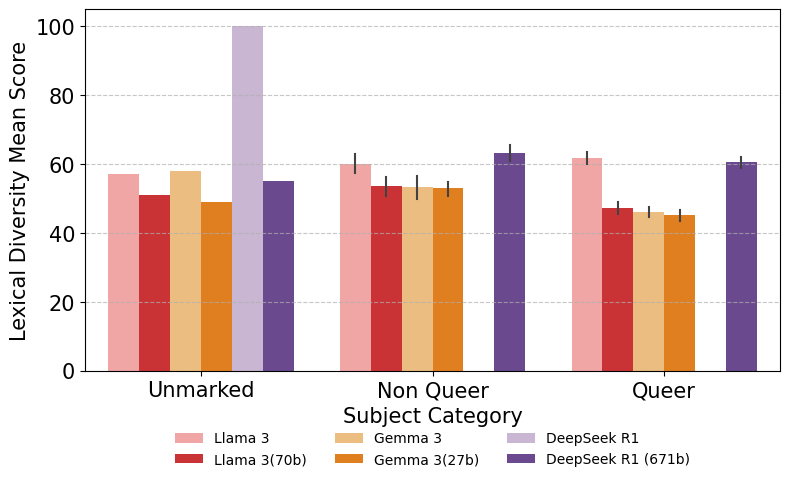

In [11]:
def get_lexical_diversity_scores(model, prompt_num = "prompt_0"):
    data = pd.read_csv(f"{OUTPUT_EVALUATION}{prompt_num}/{model}.csv")
    # Containers for results
    downsampled_scores = []  # Stores individual downsampled scores
    overall_scores = []      # Stores overall average scores
    categories_for_downsample = []  # One entry per downsampled score

    # Loop over each subject category
    for category in SUBJ_CATEGORIES:
        df_category = data[data[TYPE] == category].dropna(subset=[PREDICTION])

        # --- Overall score ---
        overall_diversity = round(len(set(df_category[PREDICTION])) / len(df_category) * 100, 2)
        overall_scores.append(int(overall_diversity))

        # --- Downsampled scores ---
        if category == UNMARKED:
            # For small groups, use only the overall score as downsampled too
            downsampled_scores.append(int(overall_diversity))
            categories_for_downsample.append(category)
        else:
            # Number of batches = floor(n / 100)
            n_batches = df_category.shape[0] // 100

            for _ in range(n_batches):
                sample = df_category.sample(n=100, replace=False, random_state=random.randint(0, 10000))
                diversity = round(len(set(sample[PREDICTION])) / 100 * 100, 2)
                downsampled_scores.append(int(diversity))
                categories_for_downsample.append(category)

    # Create DataFrame for downsampled scores (multiple per category)
    df_downsampling = pd.DataFrame({
        "model": MODELS_LABELS[model],
        "type": categories_for_downsample,
        "downsampled_mean": downsampled_scores
    })
    df_downsampling['type'] = pd.Categorical(df_downsampling["type"], categories=SUBJ_CATEGORIES, ordered=True)

    # Create DataFrame for overall scores (one per category)
    df_overall = pd.DataFrame({
        "model": MODELS_LABELS[model],
        "type": SUBJ_CATEGORIES,
        "mean": overall_scores
    })
    df_overall['type'] = pd.Categorical(df_overall["type"], categories=SUBJ_CATEGORIES, ordered=True)
    
    return df_downsampling, df_overall 

def plot_mean_with_error_bars(models, img_name):
    df_downsampling_combined = pd.DataFrame()
    df_overall_combined= pd.DataFrame()
    
    table_results = []
    for model in models:
        df_downsampling, df_overall = get_lexical_diversity_scores(model)

        #display(df_downsampling)
        #display(df_overall)
        
        for subject_category in SUBJ_CATEGORIES:
            downsampled_means_list = df_downsampling[df_downsampling["type"] == subject_category]["downsampled_mean"].values #Get the downsampled mean of that category
            print(subject_category, downsampled_means_list)
            
            overall_mean = df_overall[df_overall["type"] == subject_category]["mean"].values[0] #Get the overall mean
            print(overall_mean)
            mean, std, h = compute_mean_ci(downsampled_means_list)
            table_results.append({
                "model": MODELS_LABELS[model],
                "type": subject_category,
                "mean": overall_mean,
                'downsampled_mean': mean,
                'downsampled_mean_CI': round(h,3),
                'std': round(std,3)
            })
            
        df_downsampling_combined = pd.concat([df_downsampling_combined ,df_downsampling])
        df_overall_combined = pd.concat([df_overall_combined, df_overall])


    table_results = pd.DataFrame(table_results)
    table_results.to_csv(PATH_DIVERSITY_TABLE+f'{img_name}.csv')
    #display(table_results)
    
    
    display(df_downsampling_combined)
    # Plotting
    
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(
        data=df_downsampling_combined,
        x="type",
        y='downsampled_mean',
        hue='model',
        palette=get_palette(models),
        err_kws={ "linewidth": 1.5},
        #capsize=.4,
        #legend=None
    )

    sns.move_legend(
        ax, "lower center",
        bbox_to_anchor=(.5, -0.3), ncol=3, title=None, frameon=False,
    )
    
    # display(df_overall_combined)
    # sns.barplot(
    #     data=df_overall_combined,
    #     x='type',
    #     y='mean',
    #     hue='model',
    #     # palette=get_palette(models),
    #     legend=None,
    #     # errorbar=("pi", 50), 
    #     #capsize=.4,
    #     # err_kws={"color": ".5", "linewidth": 2.5},
    #     # linewidth=2.5, 
    #     edgecolor="red", 
    #     facecolor=(0, 0, 0, 0),
    # )

    # # sns.catplot(
    # #     df_downsampling_combined, kind="bar",
    # #     x="type", y="downsampled_mean", col="model",
    # #     height=4, aspect=.5,
    # # )


    #plt.title('Mean Score per Category (with Error Bars from Downsampling)')
    ax.grid(visible=True, axis='y', linestyle='--', alpha=0.7)
    ax.tick_params(axis='both', labelsize=LABELSIZE)
    #plt.xticks(rotation=25)
    plt.ylabel('Lexical Diversity Mean Score', fontsize = LABELSIZE)
    plt.xlabel('Subject Category', fontsize = LABELSIZE)
    plt.tight_layout()
    plt.savefig(os.path.join(PATH_DIVERSITY_GRAPH, f'{img_name}.png'))
    plt.show()
    

for model_group, name in [
    #(MODEL_MLM, MLM_MODELS),
    (MODEL_OPEN, OPEN_MODELS),
    #(MODEL_CLOSE, CLOSE_MODELS)
]:
    plot_mean_with_error_bars(model_group, name)


In [4]:
# --- Function to compute model-level data with CI for Perspective and VADER ---
def get_sentiment_toxicity_scores(model, prompt_num = "prompt_0"):
    df = pd.read_csv(f"{OUTPUT_EVALUATION}{prompt_num}/{model}.csv")
    df['Model'] = MODELS_LABELS.get(model, model)
    df['type'] = pd.Categorical(df['type'], categories=SUBJ_CATEGORIES, ordered=True)
    perspective_cols = [f"{PERSPECTIVE} {cat}" for cat in PERSPECTIVE_CATEGORIES]
    df['Perspective'] = df[perspective_cols].mean(axis=1)

    downsampled_rows = []
    overall_rows = []

    for category in SUBJ_CATEGORIES:
        df_cat = df[df['type'] == category].dropna(subset=['Perspective', 'VADER'])

        # Overall means
        overall_perspective = df_cat['Perspective'].mean()
        overall_vader = df_cat['VADER'].mean()
        overall_rows.append({
            "Model": MODELS_LABELS[model],
            "type": category,
            "Perspective": overall_perspective,
            "VADER": overall_vader
        })

        # Downsampling
        n_batches = df_cat.shape[0] // 100 if category != UNMARKED else 1

        for _ in range(n_batches):
            sample = df_cat.sample(n=100, replace=False, random_state=random.randint(0, 10000))
            perspective_mean = sample['Perspective'].mean()
            vader_mean = sample['VADER'].mean()
            downsampled_rows.append({
                "Model": MODELS_LABELS[model],
                "type": category,
                "Perspective": perspective_mean,
                "VADER": vader_mean
            })

        if category == UNMARKED:
            downsampled_rows.append({
                "Model": MODELS_LABELS[model],
                "type": category,
                "Perspective": overall_perspective,
                "VADER": overall_vader
            })

    df_downsampled = pd.DataFrame(downsampled_rows)
    df_downsampled['type'] = pd.Categorical(df_downsampled['type'], categories=SUBJ_CATEGORIES, ordered=True)

    df_overall = pd.DataFrame(overall_rows)
    df_overall['type'] = pd.Categorical(df_overall['type'], categories=SUBJ_CATEGORIES, ordered=True)

    return df_downsampled, df_overall

# --- Plotting Function ---
def plot_sentiment_toxicity_with_ci(models, img_name):
    df_downsampled_all = pd.DataFrame()
    df_overall_all = pd.DataFrame()
    table_results = []

    for model in models:
        df_downsampled, df_overall = get_sentiment_toxicity_scores(model)

        for category in SUBJ_CATEGORIES:
            cat_data = df_downsampled[df_downsampled['type'] == category]
            for metric in ['Perspective', 'VADER']:
                mean, std, h = compute_mean_ci(cat_data[metric])
                table_results.append({
                    "Model": MODELS_LABELS[model],
                    "type": category,
                    "Metric": metric,
                    "mean": df_overall[df_overall['type'] == category][metric].values[0],
                    f"{metric}_CI": round(h, 3),
                    f"{metric}_STD": round(std, 3),
                })

        df_downsampled_all = pd.concat([df_downsampled_all, df_downsampled])
        df_overall_all = pd.concat([df_overall_all, df_overall])

    df_table = pd.DataFrame(table_results)
    df_table.to_csv(PATH_SENTIMENT_TABLE + f"{img_name}.csv")
    df_table.to_csv(PATH_TOXICITY_TABLE + f"{img_name}.csv")

    # Plot VADER
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        data=df_downsampled_all,
        x='type',
        y='VADER',
        hue='Model',
        palette=get_palette(models),
        err_kws={"linewidth": 1.5},
        capsize=.4,
    )
    ax.grid(visible=True, axis='y', linestyle='--', alpha=0.7)
    ax.tick_params(axis='both', labelsize=LABELSIZE)
    plt.ylabel('VADER Average Score', fontsize=LABELSIZE)
    plt.xlabel('Subject Category', fontsize=LABELSIZE)
    plt.legend(title='Model', fontsize=LABELSIZE, title_fontsize=LABELSIZE)
    sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)
    plt.tight_layout()
    plt.savefig(os.path.join(PATH_SENTIMENT_GRAPH, f'{img_name}.png'))
    plt.show()

    # Plot Perspective
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        data=df_downsampled_all,
        x='type',
        y='Perspective',
        hue='Model',
        palette=get_palette(models),
        err_kws={"linewidth": 1.5},
        capsize=.4,
        legend=None
    )
    ax.grid(visible=True, axis='y', linestyle='--', alpha=0.7)
    ax.tick_params(axis='both', labelsize=LABELSIZE)
    plt.ylabel('Perspective Average Score', fontsize=LABELSIZE)
    plt.xlabel('Subject Category', fontsize=LABELSIZE)
    plt.tight_layout()
    plt.savefig(os.path.join(PATH_TOXICITY_GRAPH, f'{img_name}.png'))
    plt.show()
    
# for model_group, name in [
#     (MODEL_MLM, MLM_MODELS),
#     (MODEL_OPEN, OPEN_MODELS),
#     (MODEL_CLOSE, CLOSE_MODELS)
# ]:
#     plot_sentiment_toxicity_with_ci(model_group, name)

# Regard

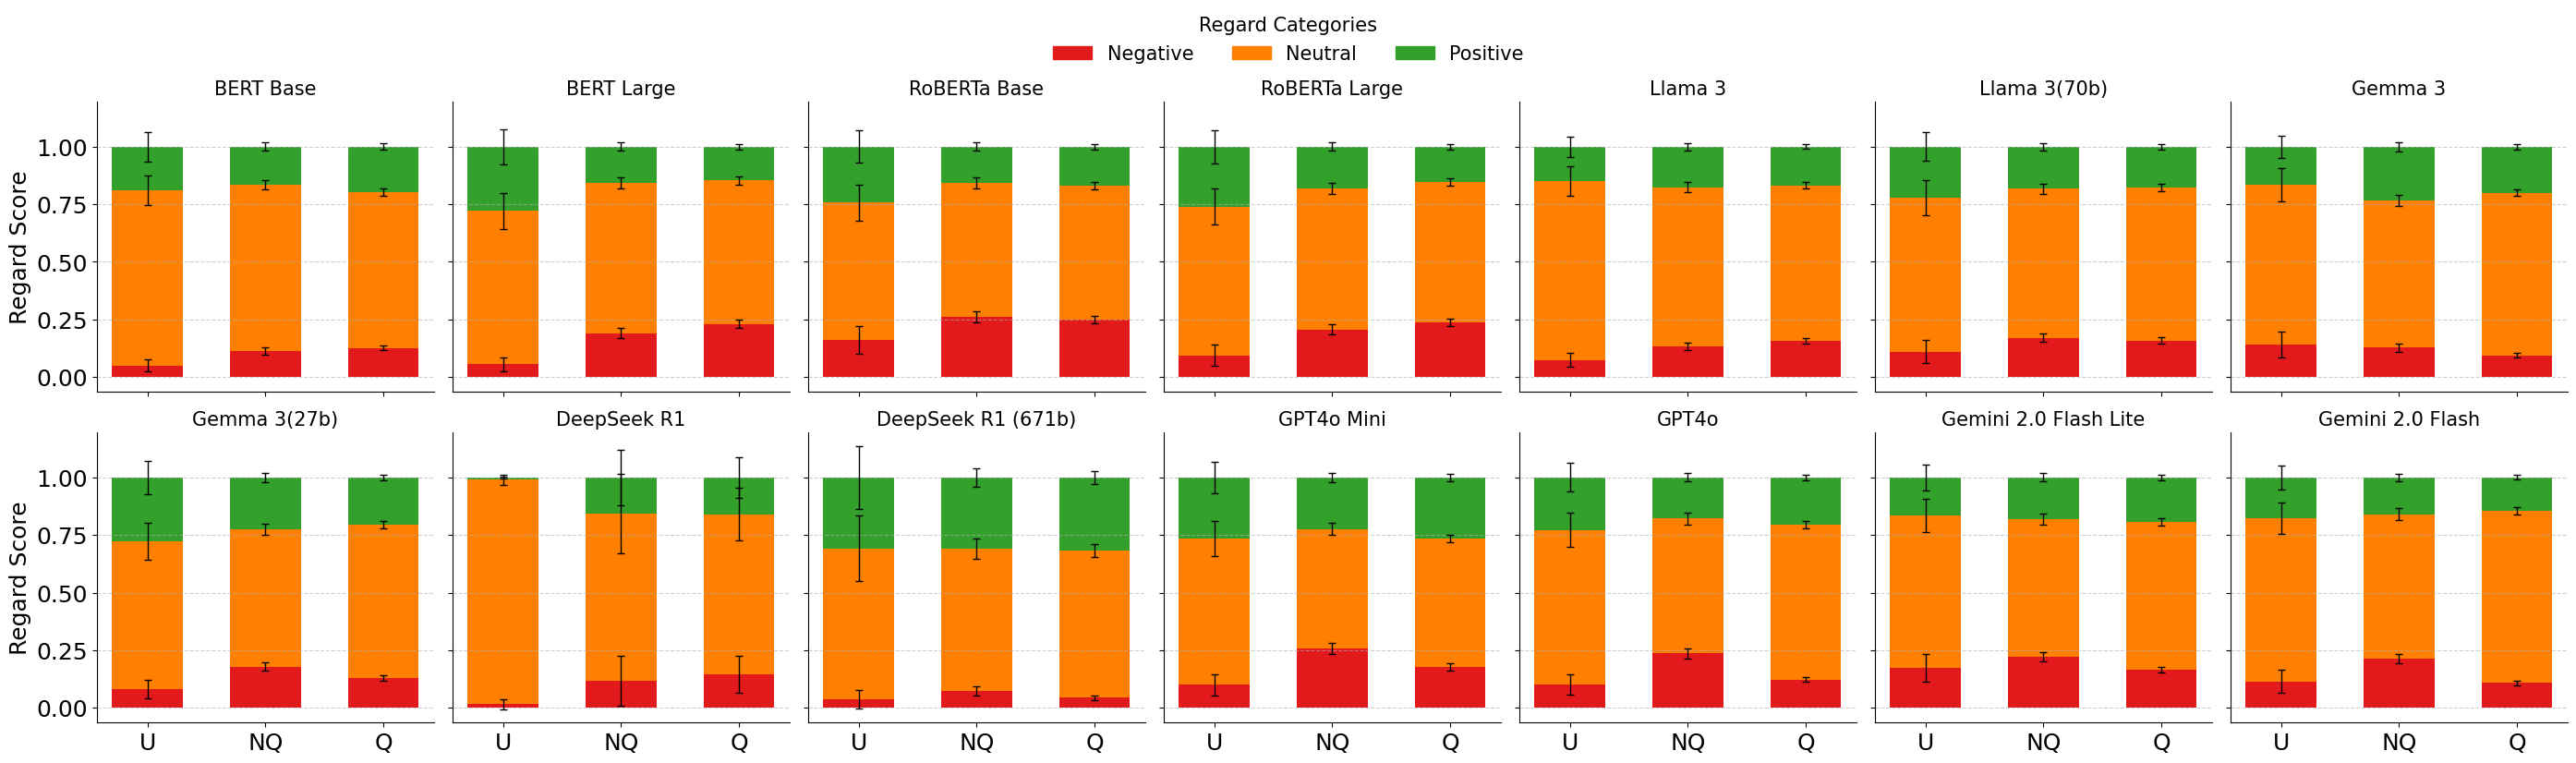

In [5]:
def regard_bar_graph_seaborn(models, img_name, models_per_row, prompt_num = "prompt_0"):
    records = []

    for model in models:
        data = pd.read_csv(f"{OUTPUT_EVALUATION}{prompt_num}/{model}.csv")
        for subjCat in SUBJ_CATEGORIES:
            df = data[data[TYPE] == subjCat]
            means = []
            cis = []
            for cat in REGARD_CATEGORIES:
                vals = df[f"Regard {cat}"].dropna().values
                m, _, h = compute_mean_ci(vals)
                means.append(m)
                cis.append(h)
            
            score_sum = sum(means)
            if score_sum == 0:
                normalized = [0] * len(means)
                norm_cis = [0] * len(means)
            else:
                normalized = [v / score_sum for v in means]
                # Normalize confidence intervals too (approximated)
                norm_cis = [h / score_sum for h in cis]
            
            for i, category in enumerate(REGARD_CATEGORIES):
                records.append({
                    "Model": MODELS_LABELS.get(model, model),
                    "Subject": subjCat,
                    "Regard": category,
                    "Score": normalized[i],
                    "CI": norm_cis[i],
                    "Color": REGARD_MAP[category]
                })

    df_long = pd.DataFrame(records)
    df_long["Subject"] = pd.Categorical(df_long["Subject"], categories=SUBJ_CATEGORIES, ordered=True)
    df_long["Regard"] = pd.Categorical(df_long["Regard"], categories=REGARD_CATEGORIES, ordered=True)
    df_to_save = df_long.drop(columns=['Color']).copy()
    df_to_save['Score'] = df_to_save['Score'].round(2)
    df_to_save['CI'] = df_to_save['CI'].round(2)
    df_to_save.to_csv(PATH_REGARD_TABLE + f'{img_name}.csv', index=False)
    
    n_models = len(models)
    num_cols = min(models_per_row, n_models)

    g = sns.FacetGrid(
        df_long,
        col="Model",
        col_wrap=models_per_row,
        height=4,
        sharey=True
    )

    def stacked_barplot(data, **kwargs):
        LABELSIZE = 18
        ax = plt.gca()
        bottoms = np.zeros(len(SUBJ_CATEGORIES))
        for i, category in enumerate(REGARD_CATEGORIES):
            subset = data[data["Regard"] == category].sort_values("Subject")
            scores = subset["Score"].values
            cis = subset["CI"].values
            x = np.arange(len(SUBJ_CATEGORIES))
            ax.bar(
                x,
                scores,
                bottom=bottoms,
                color=REGARD_MAP[category],
                width=0.6,
                label=category
            )
            # Add CI bars on top of current segment
            ax.errorbar(
                x,
                bottoms + scores,
                yerr=cis,
                fmt='none',
                ecolor='black',
                capsize=3,
                linewidth=1
            )
            bottoms += scores

        ax.set_xticks(x)
        ax.set_xticklabels(["U", "NQ", "Q"], fontsize=LABELSIZE)
        ax.tick_params(axis='y', labelsize=LABELSIZE)
        ax.set_xlabel("")
        ax.set_ylabel("Regard Score", fontsize=LABELSIZE)
        ax.grid(visible=True, axis='y', linestyle='--', alpha=0.6)

    g.map_dataframe(stacked_barplot)
    g.set_titles("{col_name}", size=LABELSIZE)
    g.set_axis_labels("", "Regard Score")
    g.fig.subplots_adjust(top=0.88)

    # Legend on top without rectangle
    handles = [plt.Rectangle((0,0),1,1, color=REGARD_MAP[category]) for category in REGARD_CATEGORIES]
    g.fig.legend(
        handles,
        REGARD_CATEGORIES,
        title="Regard Categories",
        title_fontsize=LABELSIZE,
        fontsize=LABELSIZE,
        loc="upper center",
        ncol=len(REGARD_CATEGORIES),
        frameon=False,
        bbox_to_anchor=(0.5, 1.04)
    )

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(PATH_REGARD_GRAPH + img_name + '.png', bbox_inches='tight')
    plt.show()
    plt.close()

# Example call
regard_bar_graph_seaborn(
    models=MODEL_LIST_FULL,
    img_name="all",
    models_per_row=7
)


# Marker Charts

## Toxicity

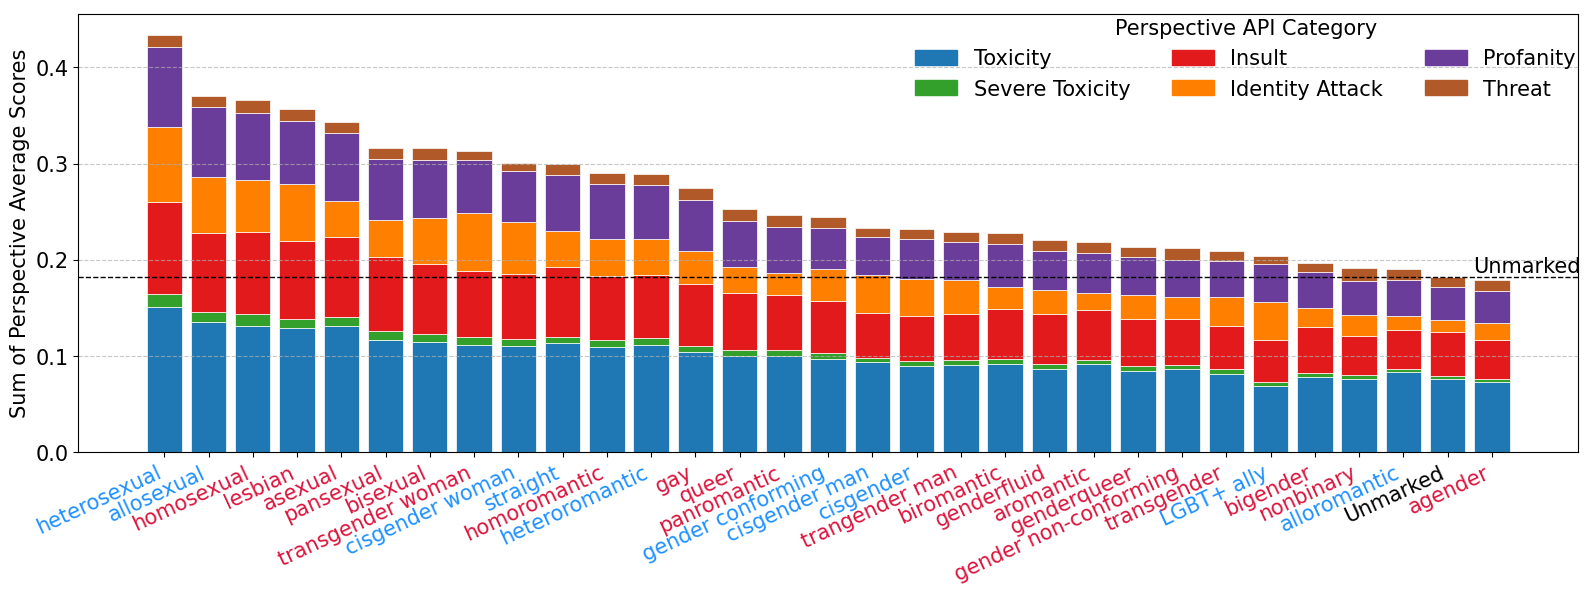

In [6]:
def toxicity_markers_bar_chart(models, img_name, prompt_num = "prompt_0"):
    template_complete_df = pd.read_csv(DATA_SOURCE + 'template_complete.csv')
    marker_type_pairs = template_complete_df.set_index(MARKER)[TYPE].to_dict()
    
    df_list = []
    for model in models:
        df = pd.read_csv(f"{OUTPUT_EVALUATION}{prompt_num}/{model}.csv")
        for cat in PERSPECTIVE_CATEGORIES:
            df[cat] = df[f"{PERSPECTIVE} {cat}"].astype(float)
        df["Perspective AVG"] = df[PERSPECTIVE_CATEGORIES].mean(axis=1) 
        df_list.append(df)

    combined_df = pd.concat(df_list)
    average_df = combined_df.groupby(MARKER)[PERSPECTIVE_CATEGORIES + ["Perspective AVG"]].mean().sort_values("Perspective AVG", ascending=False)
    fig, ax = plt.subplots(figsize=(16, 6))
    bar_positions = np.arange(len(average_df))
    bottom = np.zeros(len(average_df))

    #display(average_df)
    
    for cat in PERSPECTIVE_CATEGORIES:
        values = average_df[cat]
        ax.bar(
            bar_positions,
            values,
            width=0.8,
            bottom=bottom,
            label=PERSPECTIVE_MAP[cat][LABEL],
            color=PERSPECTIVE_MAP[cat][COLOR],
            edgecolor='white',
            linewidth=0.5
        )
        bottom += values.values

    unmarked_total = average_df.loc["Unmarked"][PERSPECTIVE_CATEGORIES].sum()
    ax.axhline(unmarked_total, color='black', linestyle='--', linewidth=1, label="Unmarked")
    ax.text(32, unmarked_total, "Unmarked", ha='right', va='bottom', fontsize=LABELSIZE, color='black')

    ax.set_ylabel("Sum of Perspective Average Scores", fontsize=LABELSIZE)
    ax.tick_params(axis='both', labelsize=LABELSIZE)
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(average_df.index, rotation=25, ha="right")

    for tick, label in zip(ax.get_xticks(), ax.get_xticklabels()):
        marker = label.get_text()
        marker_type = marker_type_pairs.get(marker)
        if marker_type:
            label.set_color(MARKER_COLOR_MAP.get(marker_type, 'black'))

    ax.grid(visible=True, axis='y', linestyle='--', alpha=0.7)
    handles = [plt.Rectangle((0,0),1,1, color=PERSPECTIVE_MAP[cat][COLOR]) for cat in PERSPECTIVE_CATEGORIES]
    labels = [PERSPECTIVE_MAP[cat][LABEL] for cat in PERSPECTIVE_CATEGORIES]

    fig.legend(
        handles, 
        labels, 
        title="Perspective API Category", 
        loc="upper right", 
        #borderaxespad=0.1, 
        frameon=False,
        fontsize=LABELSIZE, 
        title_fontsize=LABELSIZE, 
        ncol=3
    )
    plt.tight_layout()
    plt.savefig(PATH_TOXICITY_GRAPH + img_name + '.png', bbox_inches='tight')
    plt.show()
    plt.close()

toxicity_markers_bar_chart(MODEL_LIST_FULL, "marker_chart")

## Regard

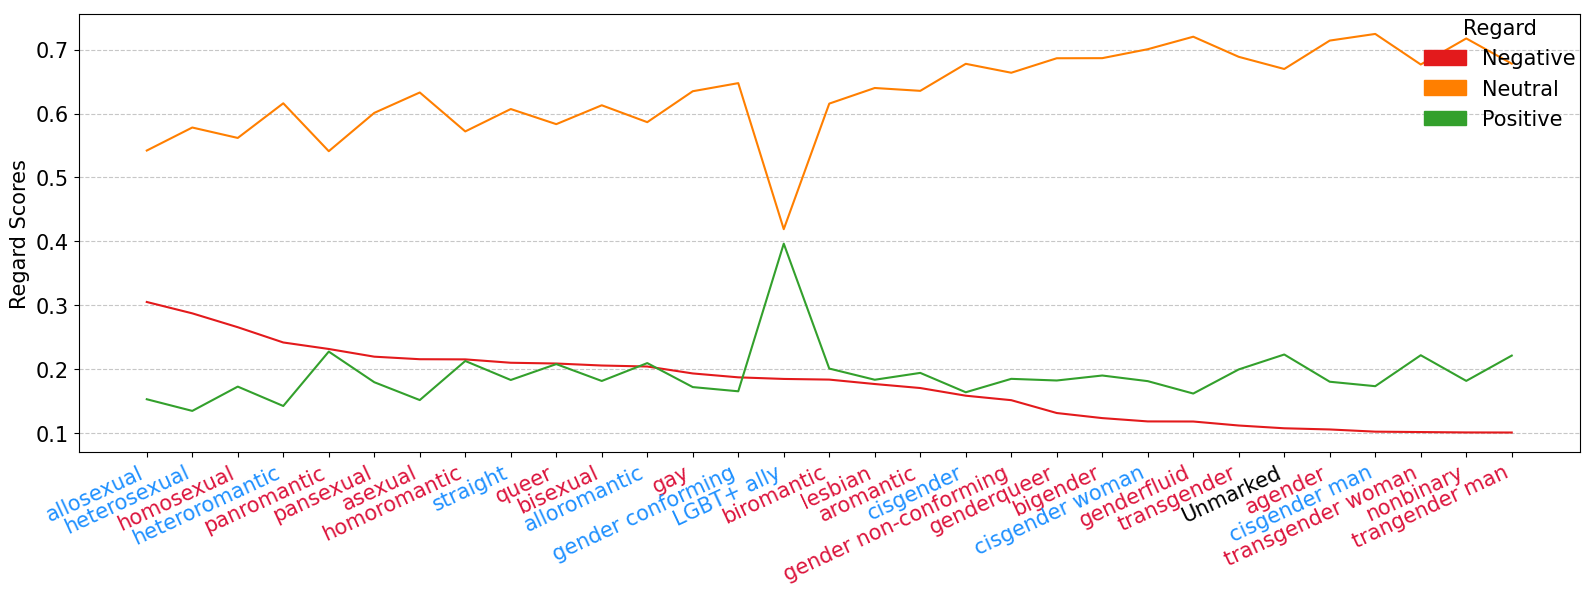

In [7]:
def regard_markers_bar_chart(models, img_name, prompt_num = "prompt_0"):
    template_complete_df = pd.read_csv(DATA_SOURCE + 'template_complete.csv')
    marker_type_pairs = template_complete_df.set_index(MARKER)[TYPE].to_dict()
    
    df_list = []
    for model in models:
        df = pd.read_csv(f"{OUTPUT_EVALUATION}{prompt_num}/{model}.csv")
        
        # Convert scores to float and normalize by row-wise sum
        for cat in REGARD_CATEGORIES:
            df[cat] = df[f"{REGARD} {cat}"].astype(float)
        
        row_sum = df[REGARD_CATEGORIES].sum(axis=1)
        df[REGARD_CATEGORIES] = df[REGARD_CATEGORIES].div(row_sum, axis=0)
        
        df_list.append(df)

    combined_df = pd.concat(df_list)
    average_df = combined_df.groupby(MARKER)[REGARD_CATEGORIES].mean().sort_values(REGARD_CATEGORIES[0], ascending=False)
    #display(average_df)
    
    fig, ax = plt.subplots(figsize=(16, 6))
    bar_positions = np.arange(len(average_df))
    bottom = np.zeros(len(average_df))

    for cat in REGARD_CATEGORIES:
        ax = sns.lineplot(
            data=average_df,
            x=MARKER,
            y=cat,
            color= REGARD_MAP[cat],
            label = cat,
            legend=None
        )
        
    
    # for cat in REGARD_CATEGORIES:
    #     values = average_df[cat]
    #     ax.bar(
    #         bar_positions,
    #         values,
    #         width=0.8,
    #         bottom=bottom,
    #         # label=REGARD_CATEGORIES,
    #         color=REGARD_MAP[cat],
    #         edgecolor='white',
    #         linewidth=0.5
    #     )
    #     bottom += values.values

    # unmarked_total = average_df.loc["Unmarked"][REGARD_CATEGORIES].sum()
    # ax.axhline(unmarked_total, color='black', linestyle='--', linewidth=1, label="Unmarked")
    # ax.text(32, unmarked_total, "Unmarked", ha='right', va='bottom', fontsize=LABELSIZE, color='black')

    ax.set_ylabel("Regard Scores", fontsize=LABELSIZE)
    ax.set_xlabel(None)
    ax.tick_params(axis='both', labelsize=LABELSIZE)
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(average_df.index, rotation=25, ha="right")

    for tick, label in zip(ax.get_xticks(), ax.get_xticklabels()):
        marker = label.get_text()
        marker_type = marker_type_pairs.get(marker)
        if marker_type:
            label.set_color(MARKER_COLOR_MAP.get(marker_type, 'black'))

    ax.grid(visible=True, axis='y', linestyle='--', alpha=0.7)
    handles = [plt.Rectangle((0,0),1,1, color=REGARD_MAP[cat]) for cat in REGARD_CATEGORIES]
    labels = [cat for cat in REGARD_CATEGORIES]

    fig.legend(
        handles, 
        labels, 
        title="Regard", 
        loc="upper right", 
        #borderaxespad=0.1, 
        frameon=False,
        fontsize=LABELSIZE, 
        title_fontsize=LABELSIZE, 
        ncol=1
    )
    plt.tight_layout()
    plt.savefig(PATH_REGARD_GRAPH + img_name + '.png', bbox_inches='tight')
    plt.show()
    plt.close()
    
regard_markers_bar_chart(MODEL_LIST_FULL, "marker_chart")

## Sentiment

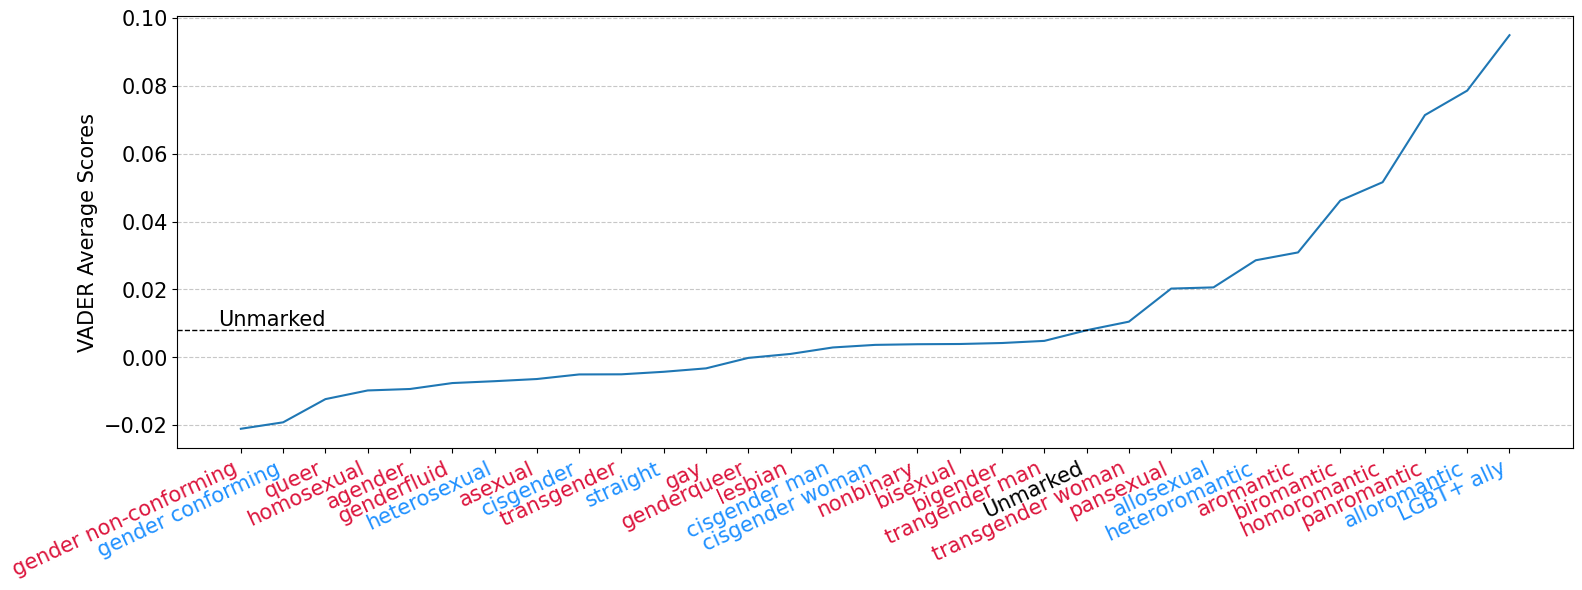

In [8]:

def toxicity_markers_bar_chart(models, img_name, prompt_num = "prompt_0"):
    template_complete_df = pd.read_csv(DATA_SOURCE + 'template_complete.csv')
    marker_type_pairs = template_complete_df.set_index(MARKER)[TYPE].to_dict()
    
    df_list = []
    for model in models:
        df = pd.read_csv(f"{OUTPUT_EVALUATION}{prompt_num}/{model}.csv")
        df_list.append(df)

    combined_df = pd.concat(df_list)
    average_df = combined_df.groupby(MARKER)[[VADER]].mean().sort_values(VADER, ascending=True)
    fig, ax = plt.subplots(figsize=(16, 6))
    bar_positions = np.arange(len(average_df))

    ax = sns.lineplot(
        data=average_df,
        x=MARKER,
        y=VADER,
        legend=None
    )
    unmarked_total = average_df.loc["Unmarked"][VADER]
    ax.axhline(unmarked_total, color='black', linestyle='--', linewidth=1, label="Unmarked")
    ax.text(2, unmarked_total, "Unmarked", ha='right', va='bottom', fontsize=LABELSIZE, color='black')

    ax.set_ylabel("VADER Average Scores", fontsize=LABELSIZE)
    ax.set_xlabel(None)
    ax.tick_params(axis='both', labelsize=LABELSIZE)
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(average_df.index, rotation=25, ha="right")
    ax.grid(visible=True, axis='y', linestyle='--', alpha=0.7)

    for tick, label in zip(ax.get_xticks(), ax.get_xticklabels()):
        marker = label.get_text()
        marker_type = marker_type_pairs.get(marker)
        if marker_type:
            label.set_color(MARKER_COLOR_MAP.get(marker_type, 'black'))

    plt.tight_layout()
    plt.savefig(PATH_SENTIMENT_GRAPH + img_name + '.png', bbox_inches='tight')
    plt.show()
    plt.close()

toxicity_markers_bar_chart(MODEL_LIST_FULL, "marker_chart")

## Lexical Diversity

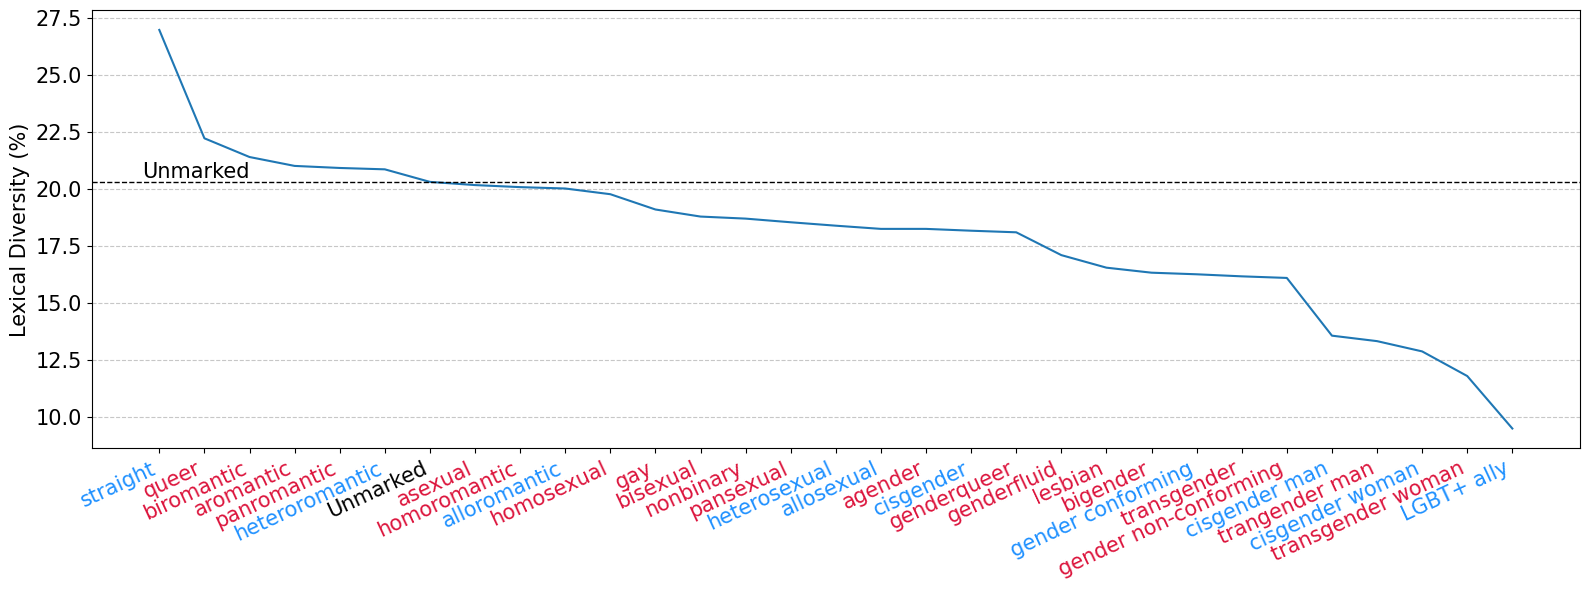

In [9]:

def lexical_diversity_markers_bar_chart(models, img_name, prompt_num = "prompt_0"):
    template_complete_df = pd.read_csv(DATA_SOURCE + 'template_complete.csv')
    marker_type_pairs = template_complete_df.set_index(MARKER)[TYPE].to_dict()
    
    df_list = []
    for model in models:
        df = pd.read_csv(f"{OUTPUT_EVALUATION}{prompt_num}/{model}.csv")
        df_list.append(df)

    combined_df = pd.concat(df_list)

    # Calculate diversity scores
    diversity_scores = []
    for marker in combined_df[MARKER].unique():
        word_list = combined_df[combined_df[MARKER] == marker][PREDICTION].values
        diversity = round(len(set(word_list)) / len(word_list) * 100, 2) if len(word_list) > 0 else 0
        diversity_scores.append({'marker': marker, 'diversity': diversity})

    # Create a new DataFrame for plotting
    diversity_df = pd.DataFrame(diversity_scores).set_index(MARKER).sort_values("diversity", ascending=False)
    
    fig, ax = plt.subplots(figsize=(16, 6))
    bar_positions = np.arange(len(diversity_df))
    
    ax = sns.lineplot(
        data=diversity_df,
        x=MARKER,
        y="diversity",
        legend=None
    )
    
    unmarked_total = diversity_df.loc["Unmarked"].values[0]
    ax.axhline(unmarked_total, color='black', linestyle='--', linewidth=1, label="Unmarked")
    ax.text(2, unmarked_total, "Unmarked", ha='right', va='bottom', fontsize=LABELSIZE, color='black')

    ax.set_ylabel("Lexical Diversity (%)", fontsize=LABELSIZE)
    ax.set_xlabel(None)
    ax.tick_params(axis='both', labelsize=LABELSIZE)
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(diversity_df.index, rotation=25, ha="right")
    ax.grid(visible=True, axis='y', linestyle='--', alpha=0.7)
    
    for tick, label in zip(ax.get_xticks(), ax.get_xticklabels()):
        marker = label.get_text()
        marker_type = marker_type_pairs.get(marker)
        if marker_type:
            label.set_color(MARKER_COLOR_MAP.get(marker_type, 'black'))

    plt.tight_layout()
    plt.savefig(PATH_DIVERSITY_GRAPH + img_name + '.png', bbox_inches='tight')
    plt.show()
    plt.close()

lexical_diversity_markers_bar_chart(MODEL_LIST_FULL, "marker_chart")

# Statistical Testing

In [10]:
def statistical_testing_table(models, prompt_num = "prompt_0"):
    all_scores = [] 
    for model in models:
        df = pd.read_csv(f"{OUTPUT_EVALUATION}{prompt_num}/{model}.csv")
        df['Model'] = MODELS_LABELS.get(model, model)
        df['type'] = pd.Categorical(df['type'], categories=SUBJ_CATEGORIES, ordered=True)

        result_row = {"Model": MODELS_LABELS.get(model, model)}

        for tool in [VADER, "Perspective AVG"] + [REGARD +" "+ cat for cat in REGARD_CATEGORIES]:
            scores = {subj: df[df[TYPE] == subj][tool].dropna().values for subj in SUBJ_CATEGORIES}

            # Perform ANOVA
            f_statistic, p_value = f_oneway(*[scores[subj] for subj in SUBJ_CATEGORIES])
            #print(f"{tool} - F-statistic: {f_statistic:.3f}, P-value: {p_value:.3g}")

            # Save formatted result
            result_row[f"{tool} F"] = round(f_statistic, 3)
            result_row[f"{tool} p"] = round(p_value, 3)

        all_scores.append(result_row)

    # Create final DataFrame
    anova_results_df = pd.DataFrame(all_scores)
    display(anova_results_df)
    anova_results_df.to_csv(OUTPUT_TABLES + f'statistical_testing.csv', index=False)


statistical_testing_table(MODEL_LIST_FULL)

KeyError: 'Perspective AVG'

# Prompt comparison

In [ ]:
def plot_log_likelihood_by_prompt(models):
    df_concat = pd.DataFrame()
    
    for model in models:
        for prompt_num in PROMPTS:
            if not os.path.exists(f"{OUTPUT_EVALUATION}{prompt_num}/{model}.csv"):
                continue
            df = pd.read_csv(f"{OUTPUT_EVALUATION}{prompt_num}/{model}.csv")
            df['Model'] = MODELS_LABELS.get(model, model)
            df['Prompt'] = prompt_num
            df_concat = pd.concat([df_concat, df], ignore_index=True)

    # Compute average log-likelihood
    avg_log_likelihood = df_concat.groupby(["Model", "Prompt"])[LOG_LIKELYHOOD].mean().reset_index()

    # Sort models for consistent x-axis
    model_order = list(dict.fromkeys([MODELS_LABELS.get(m, m) for m in models] + [MODELS_LABELS.get(BERT_BASE, BERT_BASE)]))
    avg_log_likelihood['Model'] = pd.Categorical(avg_log_likelihood['Model'], categories=model_order, ordered=True)
    
    #display(avg_log_likelihood)
    
    # Plot
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=avg_log_likelihood, x="Prompt", y=LOG_LIKELYHOOD, hue="Model", marker="o")

    plt.title("Average Log-Likelihood per Model and Prompt")
    plt.ylabel("Average Log-Likelihood")
    plt.xlabel("Prompt")
    #plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend(title="Model")
    plt.grid(True)
    plt.show()


plot_log_likelihood_by_prompt([
    BERT_BASE, BERT_LARGE, ROBERTA_BASE, ROBERTA_LARGE, LLAMA3,
    LLAMA3_70B, GEMMA3, GEMMA3_27B,
    GPT4_MINI, GPT4, GEMINI_2_0_FLASH_LITE, GEMINI_2_0_FLASH
])